# Analysis of Jiu-Jitsu Competition Data


In [2]:
# Importing necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from scipy.stats import chi2_contingency


# Setting display options for better readability
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100)


## Dataset Description

This dataset is derived from a GitHub project that scrapes data from the Brazilian Jiu-Jitsu (BJJ) Heroes website. The project's repository can be found at [https://github.com/bjagrelli/bjj_data_scrapping](https://github.com/bjagrelli/bjj_data_scrapping). The dataset contains detailed information about BJJ matches and fighters.

### Columns:

- **ID**: Unique identifier for each record.
- **First Name**: Fighter's first name.
- **Last Name**: Fighter's last name.
- **Nickname**: Fighter's nickname.
- **Team**: Fighter's team or club.
- **Id**: Unique ID for the fighter.
- **Opponent**: Name of the fighter's opponent.
- **W/L**: Win or Loss status for the fighter.
- **Method**: Method of victory or defeat.
- **Competition**: Name of the BJJ competition.
- **Weight**: Weight category of the match.
- **Stage**: Stage of the competition (e.g., final, semifinal).
- **Year**: Year of the match.
- **Full Name**: Full name of the fighter.
- **Win**: Binary indicator of win (1) or loss (0).
- **Win_Streak**: Number of consecutive wins up to that match.

### Purpose:

The dataset is intended for analysis of BJJ match outcomes, fighters' performance, and competition trends. It is suitable for statistical analysis, pattern recognition, and historical data review in the context of martial arts research.


### Data Cleaning

### Initial Data State
The initial dataset obtained from the web scraping of the BJJ Heroes website was structured in a limited and condensed format. Specifically, the data was split into only 5 columns, making it difficult to analyze and extract meaningful insights directly. The columns were not distinctly separated, with multiple pieces of information combined in single columns.

### Transformation Process
To make the dataset more suitable for analysis, the following transformation steps were taken:

1. **Splitting Combined Data**: Data in single columns was split into multiple columns for better clarity and structure.
2. **Renaming Columns**: Columns were renamed to accurately represent the data they contained.
3. **Handling Missing Data**: Where applicable, missing data was identified and handled appropriately.

The Python code used for this transformation is provided below:


In [3]:
# Re-load the new data
data_new = pd.read_csv("data_new_sep.csv")

In [4]:
# Correct the column names first, assuming the first column is 'Link' which needs to be removed
data_new.columns = ['Link', 'Name', 'Sub', 'Unused1', 'Unused2']

In [5]:
# Dropping the 'Link' column from the DataFrame
data_new.drop('Link', axis=1, inplace=True)

In [6]:
# Splitting 'Name' column
split_name = data_new['Name'].str.split('|', expand=True)
data_new['First Name'] = split_name[0]
data_new['Last Name'] = split_name[1]
data_new['Nickname'] = split_name[2]
data_new['Team'] = split_name[3]

In [7]:
# Splitting 'Sub' column
split_sub = data_new['Sub'].str.split("|", expand=True)
data_new[['Id', 'Opponent', 'W/L', 'Method', 'Competition', 'Weight', 'Stage', 'Year']] = split_sub

In [8]:
def parse_method(method):
    if pd.isna(method):
        return method, None, None

    # Initial values for points and advantage
    points, advantage = None, None

    # Handling cases where 'Pts:' or 'Adv' is in the method
    if 'Pts:' in method:
        method_parts = method.split('Pts:', 1)
        method = 'Points'
        points_part = method_parts[1].strip()

        if ', Adv' in points_part:
            points, advantage = points_part.split(', ', 1)
        else:
            points = points_part

    elif method.strip() == 'Adv':
        method = 'Advantage'
        advantage = 'Adv'

    # Handling other methods
    else:
        method = method.strip()
        if method == 'Points':
            method = 'Points'
            points = 'Points'
        elif method == 'Adv':
            method = 'Advantage'
            advantage = 'Advantage'

    return method, points, advantage

In [9]:
# Apply the function to each row and create new columns
data_new[['Method', 'Points', 'Advantage']] = data_new.apply(lambda row: pd.Series(parse_method(row['Method'])), axis=1)

In [10]:
# Dropping unused columns
data_new.drop(columns=['Name', 'Sub', 'Unused1', 'Unused2'], inplace=True)

In [11]:
# Move the 'Id' column to the first position
cols = ['Id'] + [col for col in data_new if col != 'Id']
data_new = data_new[cols]

In [30]:
# Display the processed data
data_new.head()

,Id,First Name,Last Name,Nickname,Team,Opponent,W/L,Method,Competition,Weight,Stage,Year,Points,Advantage,Full Name
1,7672,Aaron,Johnson,Tex,Unity JJ,Quentin Rosensweig,L,Inside heel hook,Kakuto 5,ABS,SPF,2015,None,None,Aaron Johnson
2,8190,Aaron,Johnson,Tex,Unity JJ,Neiman Gracie,L,RNC,NoGi Pan Ams,94KG,SF,2015,None,None,Aaron Johnson
3,8785,Aaron,Johnson,Tex,Unity JJ,Richie MartinezRichie Martinez,L,Heel hook,Kakuto Challenge,ABS,SF,2015,None,None,Aaron Johnson
4,9059,Aaron,Johnson,Tex,Unity JJ,Leo NogueiraLeo Nogueira,L,Points,Atlanta W. Open,94KG,SF,2016,Points,None,Aaron Johnson
6,9116,Aaron,Johnson,Tex,Unity JJ,Abraham MarteAbraham Marte,L,Cross choke,UAEJJF NYC Pro,HWABS,4F,2016,None,None,Aaron Johnson


#### Parsing Match Outcome Methods

The `parse_method` function is employed to parse the 'Method' column, which describes the outcome of a Brazilian Jiu-Jitsu match. This function is responsible for extracting and segregating the data into two new columns: 'Points' and 'Advantage'. Here's the detailed logic of the function:

1. **Missing Values**: If the 'Method' entry is missing (NaN), both 'Points' and 'Advantage' are assigned `None`.

2. **Detailed Points Victory**: If the 'Method' includes 'Pts:' with details (e.g., "Pts: 2x0"), this denotes a victory by a specific point difference. The function extracts this detailed score into the 'Points' column.

   - When ', Adv' follows the point details (e.g., "Pts: 2x2, Adv"), it indicates a victory by advantage despite a tied score. The function parses the score into the 'Points' column and 'Adv' into the 'Advantage' column.

3. **Victory by Advantage with No Specific Points**: If 'Method' is just 'Adv', it indicates a win by advantage where the exact points are not provided. Here, 'Points' remains `None` as no specific score is available, and 'Advantage' is set to 'Adv'.

4. **Victory by Submission**: If the 'Method' specifies a submission technique, this implies a win by submission. Consequently, both 'Points' and 'Advantage' columns will be set to `None`.

5. **Victory by Points with No Specific Score**: When 'Method' contains only "Points" without further scoring details, it suggests a win on points where the precise score was not recorded. The 'Points' column will be `None` to reflect the unavailability of the score, and 'Advantage' will also be `None`.

By employing this function, the 'Method' column is effectively transformed into a structured and analytically useful format, facilitating a more straightforward assessment of the match outcomes.


In [13]:
# Function to check for repeated substrings in a string
def remove_repeated_substrings(s):
    if pd.isna(s):
        return s
    else:
        # Find all substrings
        substrings = [s[i: j] for i in range(len(s)) for j in range(i + 1, len(s) + 1)]
        
        # Sort substrings by length in descending order
        substrings.sort(key=len, reverse=True)
        
        # Check each substring
        for substring in substrings:
            # If the substring is repeated and is not a single character
            if s.count(substring) > 1 and len(substring) > 1:
                # Replace all instances of the repeated substring with a single instance
                s = s.replace(substring, substring, 1)
        return s

In [14]:
# Apply the function to 'Opponent'
data_new['Opponent'] = data_new['Opponent'].apply(remove_repeated_substrings)

In [15]:
# Strip unwanted characters from string columns
strip_cols = ['First Name', 'Last Name', 'Nickname', 'Team']
data_new[strip_cols] = data_new[strip_cols].apply(lambda x: x.str.strip(" '[],"))

In [16]:
# Combine 'First Name' and 'Last Name' into 'Full Name'
data_new['Full Name'] = data_new['First Name'] + ' ' + data_new['Last Name']

In [17]:
# Removing rows where the year is NaN or 0 
data_new['Year'] = data_new['Year'].replace(0, np.nan)

# Removing rows with NaN in 'Year'
data_new = data_new.dropna(subset=['Year'])


In [51]:
# Removing 'O' from some Weight class entries
data_new['Weight'] = data_new['Weight'].str.replace('^O', '', regex=True)

In [18]:
# Removing rows where Opponents name is "Unknown"
data_new = data_new[data_new['Opponent'] != 'Unknown']


In [19]:
# Removing rows where Submission is "N/A" or "submission"
data_new = data_new[(data_new['Method'] != 'N/A') & (data_new['Method'] != '---')]

In [20]:
# Define critical columns
critical_columns = ['Year', 'Method', 'Opponent', 'First Name', 'Last Name']

In [21]:
data_new = (data_new
                .dropna(subset=critical_columns)
                .drop_duplicates())

In [22]:
# Display the processed data
data_new.head()

,Id,First Name,Last Name,Nickname,Team,Opponent,W/L,Method,Competition,Weight,Stage,Year,Points,Advantage,Full Name
1,7672,Aaron,Johnson,Tex,Unity JJ,Quentin Rosensweig,L,Inside heel hook,Kakuto 5,ABS,SPF,2015,None,None,Aaron Johnson
2,8190,Aaron,Johnson,Tex,Unity JJ,Neiman Gracie,L,RNC,NoGi Pan Ams,94KG,SF,2015,None,None,Aaron Johnson
3,8785,Aaron,Johnson,Tex,Unity JJ,Richie MartinezRichie Martinez,L,Heel hook,Kakuto Challenge,ABS,SF,2015,None,None,Aaron Johnson
4,9059,Aaron,Johnson,Tex,Unity JJ,Leo NogueiraLeo Nogueira,L,Points,Atlanta W. Open,94KG,SF,2016,Points,None,Aaron Johnson
6,9116,Aaron,Johnson,Tex,Unity JJ,Abraham MarteAbraham Marte,L,Cross choke,UAEJJF NYC Pro,HWABS,4F,2016,None,None,Aaron Johnson


In [23]:
# Create a mask for rows where any critical column has NaN or 'None'
mask = data_new[critical_columns].isna().any(axis=1) | (data_new[critical_columns] == 'None').any(axis=1)

# Query the DataFrame using the mask
rows_with_nan_or_none = data_new[mask]

print(rows_with_nan_or_none.head())
data_frame = data_new


Empty DataFrame
Columns: [Id, First Name, Last Name, Nickname, Team, Opponent, W/L, Method, Competition, Weight, Stage, Year, Points, Advantage, Full Name]
Index: []


## Exploratory Data Analysis (EDA)

Conduct and describe your exploratory data analysis. This includes generating descriptive statistics and creating initial visualizations to understand the data better.


## Descriptive Statistics

### Basic Descriptive Statistics

In [24]:
# Assuming 'data' is your DataFrame
descriptive_stats = data_frame.describe()
print(descriptive_stats)

           Id First Name Last Name Nickname   Team              Opponent    W/L  Method   Competition Weight  Stage   Year  Points Advantage   Full Name
count   40436      40436     40436    40436  40436                 40436  40436   40436         40436  40436  40436  40436   19207      3863       40436
unique  30465        389       457      135    170                  9029      2     268          1672    116     36     51     200         1         596
top     38386      Lucas     Sousa                  Leandro LoLeandro Lo      W  Points  World Champ.    ABS     SF   2022  Points       Adv  Leandro Lo
freq        3       1165       899    29866   4375                   203  28347   19207          3978   8503  10188   5683    3540      3863         302


### Frequency Counts on Categorical Data

In [25]:
# Replace 'Method' and 'Opponent' with the actual names of your categorical columns
method_counts = data_frame['Method'].value_counts()
opponent_counts = data_frame['Opponent'].value_counts()
print("Method Counts:\n", method_counts)
print("\nOpponent Counts:\n", opponent_counts)


Method Counts:
 Method
Points                 19207
Referee Decision        3545
Choke from back         2522
Armbar                  2261
RNC                     1348
                       ...  
Scissors choke             1
Leg lock                   1
Straignt ankle lock        1
Triange armbar             1
Knee on belly/choke        1
Name: count, Length: 268, dtype: int64

Opponent Counts:
 Opponent
Leandro LoLeandro Lo            203
Fellipe AndrewFellipe Andrew    164
Gianni GrippoGianni Grippo      159
Erberth SantosErberth Santos    157
Lucas BarbosaLucas Barbosa      151
                               ... 
Gianni Criello                    1
Seth Daniel                       1
Pedro Monteiro                    1
Paulo Chermont                    1
Kevin Vieira                      1
Name: count, Length: 9029, dtype: int64


### Missing Value Analysis

In [26]:
missing_values = data_frame.isnull().sum()
missing_percentage = (missing_values / len(data_frame)) * 100
print(missing_values)
print(missing_percentage)

Id                 0
First Name         0
Last Name          0
Nickname           0
Team               0
Opponent           0
W/L                0
Method             0
Competition        0
Weight             0
Stage              0
Year               0
Points         21229
Advantage      36573
Full Name          0
dtype: int64
Id              0.000000
First Name      0.000000
Last Name       0.000000
Nickname        0.000000
Team            0.000000
Opponent        0.000000
W/L             0.000000
Method          0.000000
Competition     0.000000
Weight          0.000000
Stage           0.000000
Year            0.000000
Points         52.500247
Advantage      90.446632
Full Name       0.000000
dtype: float64


### Data Distributions

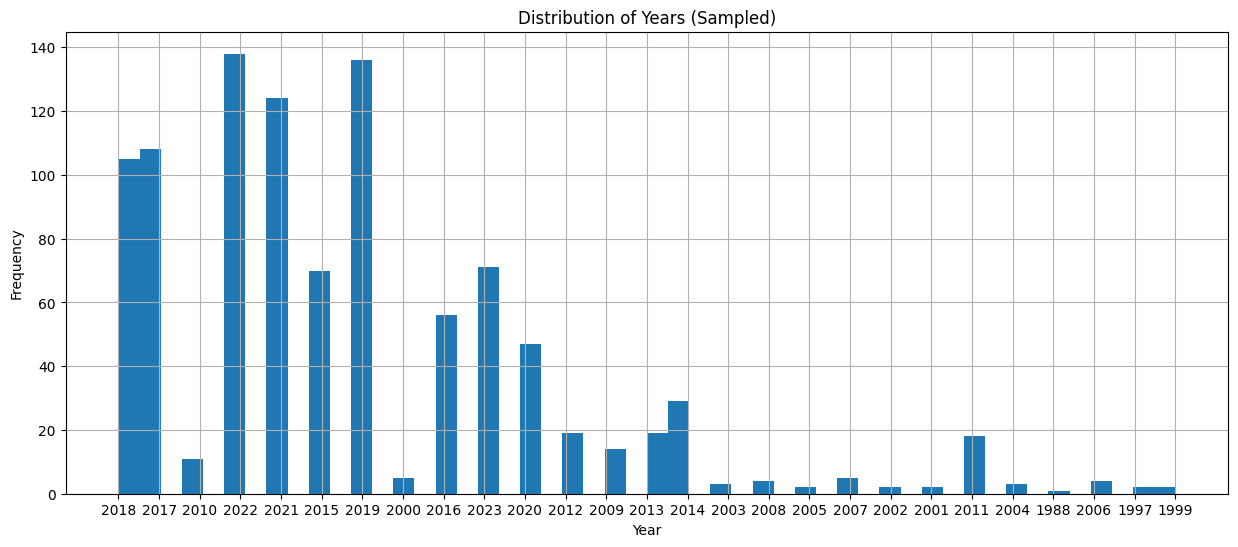

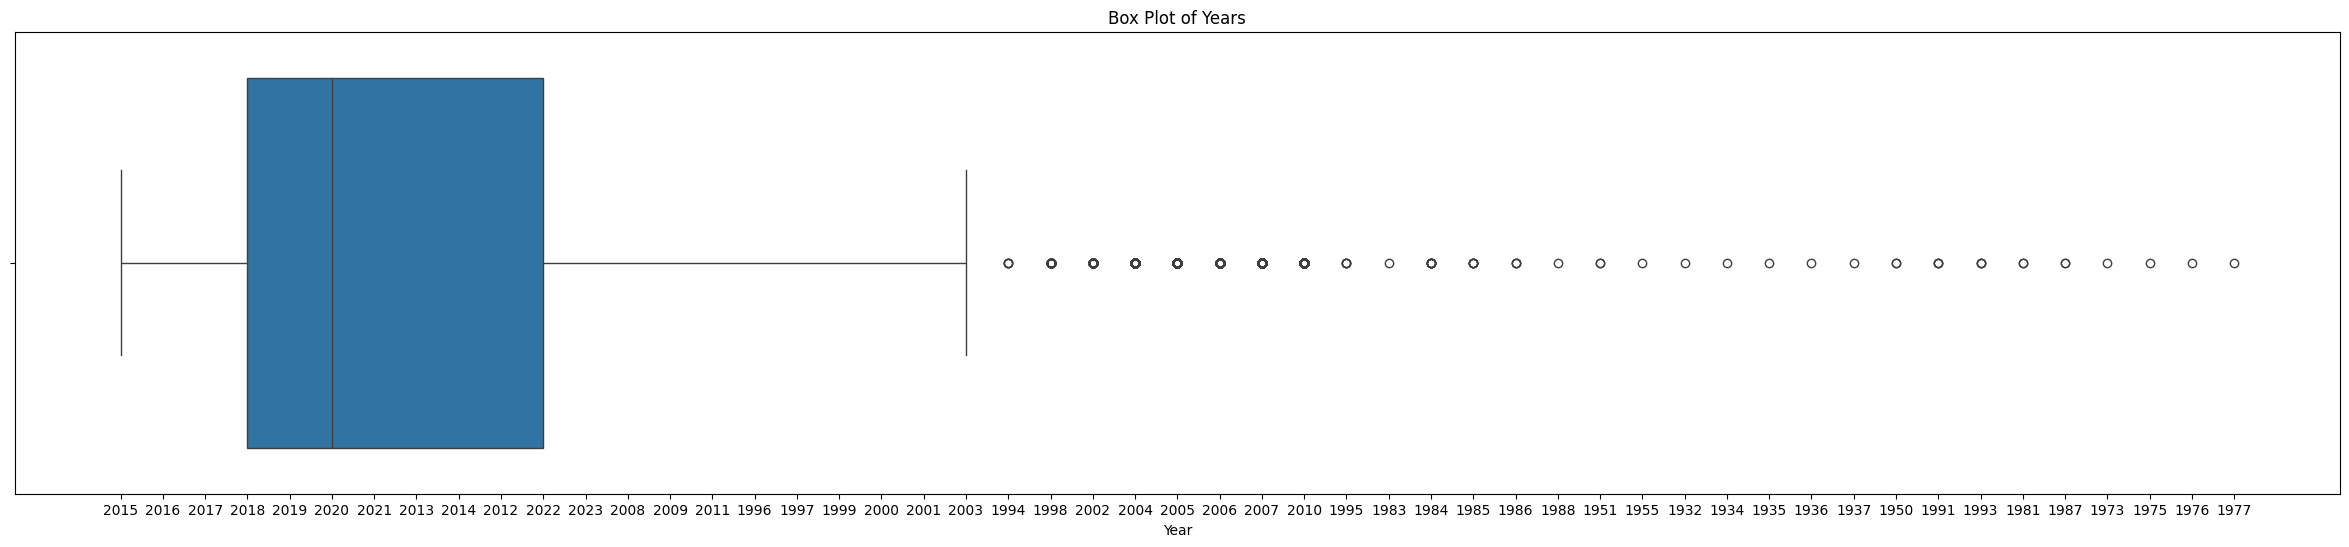

In [32]:
sampled_data = data_frame.sample(n=1000)

plt.figure(figsize=(15, 6))
sampled_data['Year'].hist(bins=50)
plt.title('Distribution of Years (Sampled)')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()


# Adjusting the width of the Box Plot
plt.figure(figsize=(30, 6))  # Adjust the size as needed
sns.boxplot(x=data_frame['Year'])
plt.title('Box Plot of Years')
plt.xlabel('Year')
plt.show()

### Statistical Analysis of Match Points

We now perform a statistical analysis on the points scored in matches. This includes calculating descriptive statistics for points scored by winners and losers in matches decided by points.

In [33]:
# Filtering for matches decided by points and calculating statistics
# points_matches = adcc_df[adcc_df['win_type'] == 'POINTS']
# winner_points_stats = points_matches['winner_points'].describe()
# loser_points_stats = points_matches['loser_points'].describe()

# Displaying the statistics
# print("Winner Points Statistics:")
# print(winner_points_stats)
# print("\nLoser Points Statistics:")
# print(loser_points_stats)

## Question Formation

### General Analysis

#### How has the frequency of competitions changed over the years?

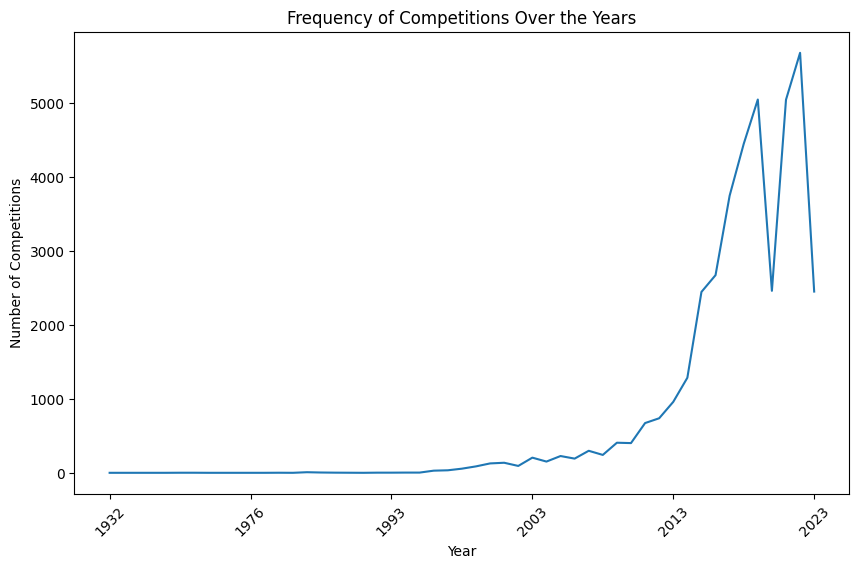

In [47]:
# Grouping by 'Year' and counting the number of competitions
competitions_per_year = data_frame.groupby('Year').size()


plt.figure(figsize=(10, 6))
competitions_per_year.plot(kind='line')
plt.title('Frequency of Competitions Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Competitions')

# Set x-ticks to only display every 5 years
plt.xticks(ticks=range(0, len(competitions_per_year), 10), 
           labels=competitions_per_year.index[::10], 
           rotation=45)
plt.show()



#### Which teams have the highest win/loss ratio

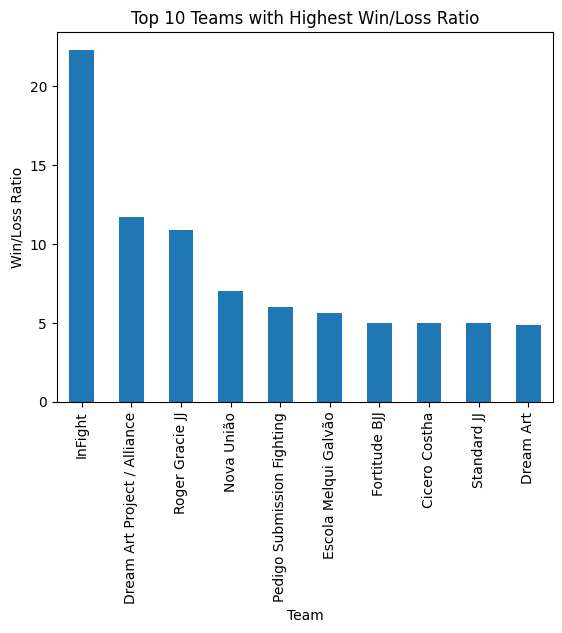

In [35]:
# Calculating wins and losses for each team
wins = data_frame[data_frame['W/L'] == 'W'].groupby('Team').size()
losses = data_frame[data_frame['W/L'] == 'L'].groupby('Team').size()

# Calculating win/loss ratio
win_loss_ratio = wins / losses

# Sorting and displaying the top 10 teams with highest win/loss ratio
top_teams = win_loss_ratio.sort_values(ascending=False).head(10)
top_teams.plot(kind='bar')
plt.title('Top 10 Teams with Highest Win/Loss Ratio')
plt.xlabel('Team')
plt.ylabel('Win/Loss Ratio')
plt.show()


#### What are the most comming winning methods

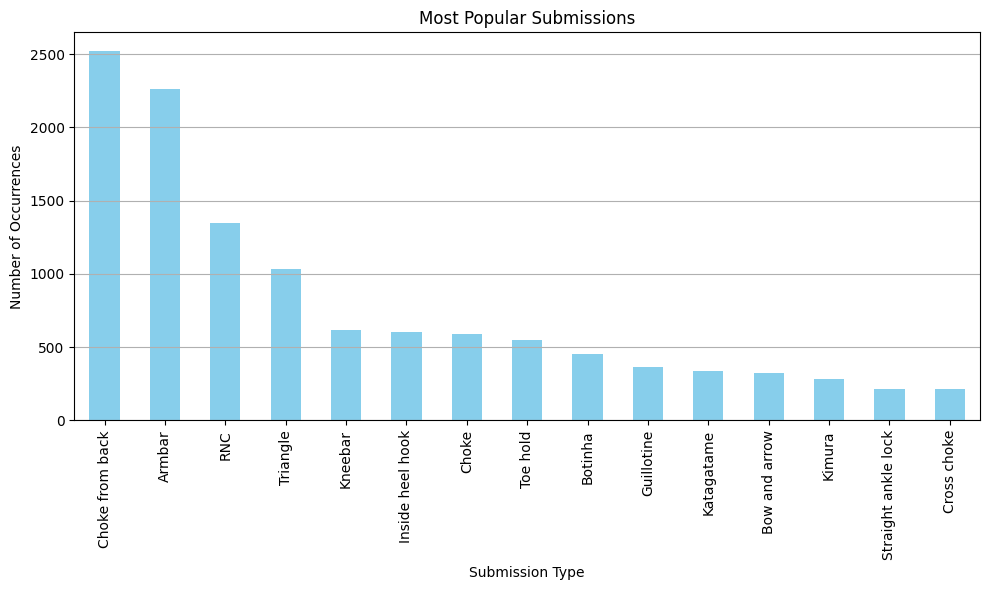

Method
Choke from back     2522
Armbar              2261
RNC                 1348
Triangle            1031
Kneebar              616
Inside heel hook     604
Choke                589
Toe hold             548
Botinha              454
Guillotine           364
Name: count, dtype: int64

In [36]:
# Filter out 'Points', 'Referee Decision', 'Submission','Advantage', 'DQ', and 'EBI/OT' from the 'Method' column
filtered_methods = data_frame[(data_frame['Method'] != 'Points') & 
                              (data_frame['Method'] != 'Referee Decision') & 
                              (data_frame['Method'] != 'Submission') & 
                              (data_frame['Method'] != 'Advantage') &
                              (data_frame['Method'] != 'DQ') &
                              (data_frame['Method'] != 'EBI/OT')]
 
# Counting the frequency of each submission type
submission_counts = filtered_methods['Method'].value_counts().head(15)

# Plotting the submission counts
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
submission_counts.plot(kind='bar', color='skyblue')
plt.title("Most Popular Submissions")
plt.xlabel("Submission Type")
plt.ylabel("Number of Occurrences")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

submission_counts.head(10)

### Participant-Focused Analysis

#### Who are the top preformers in terms of wins?

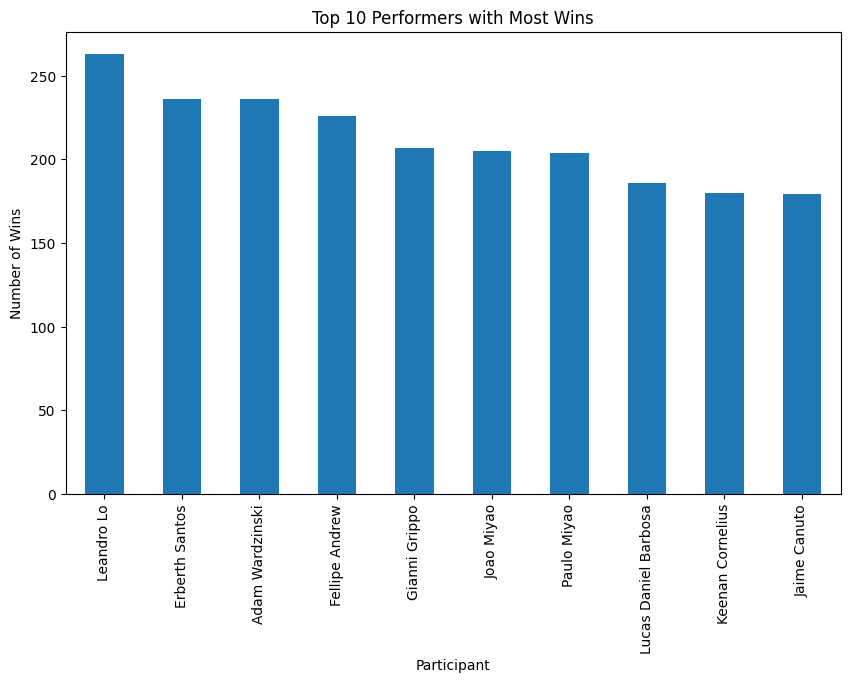

In [48]:
# Counting wins for each participant
win_counts = data_frame[data_frame['W/L'] == 'W'].groupby('Full Name').size()

# Sorting to find top performers
top_performers = win_counts.sort_values(ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 6))
top_performers.plot(kind='bar')
plt.title('Top 10 Performers with Most Wins')
plt.xlabel('Participant')
plt.ylabel('Number of Wins')
plt.show()


#### Does the 'Stage' of competition affect the likelihood of certain outcomes?

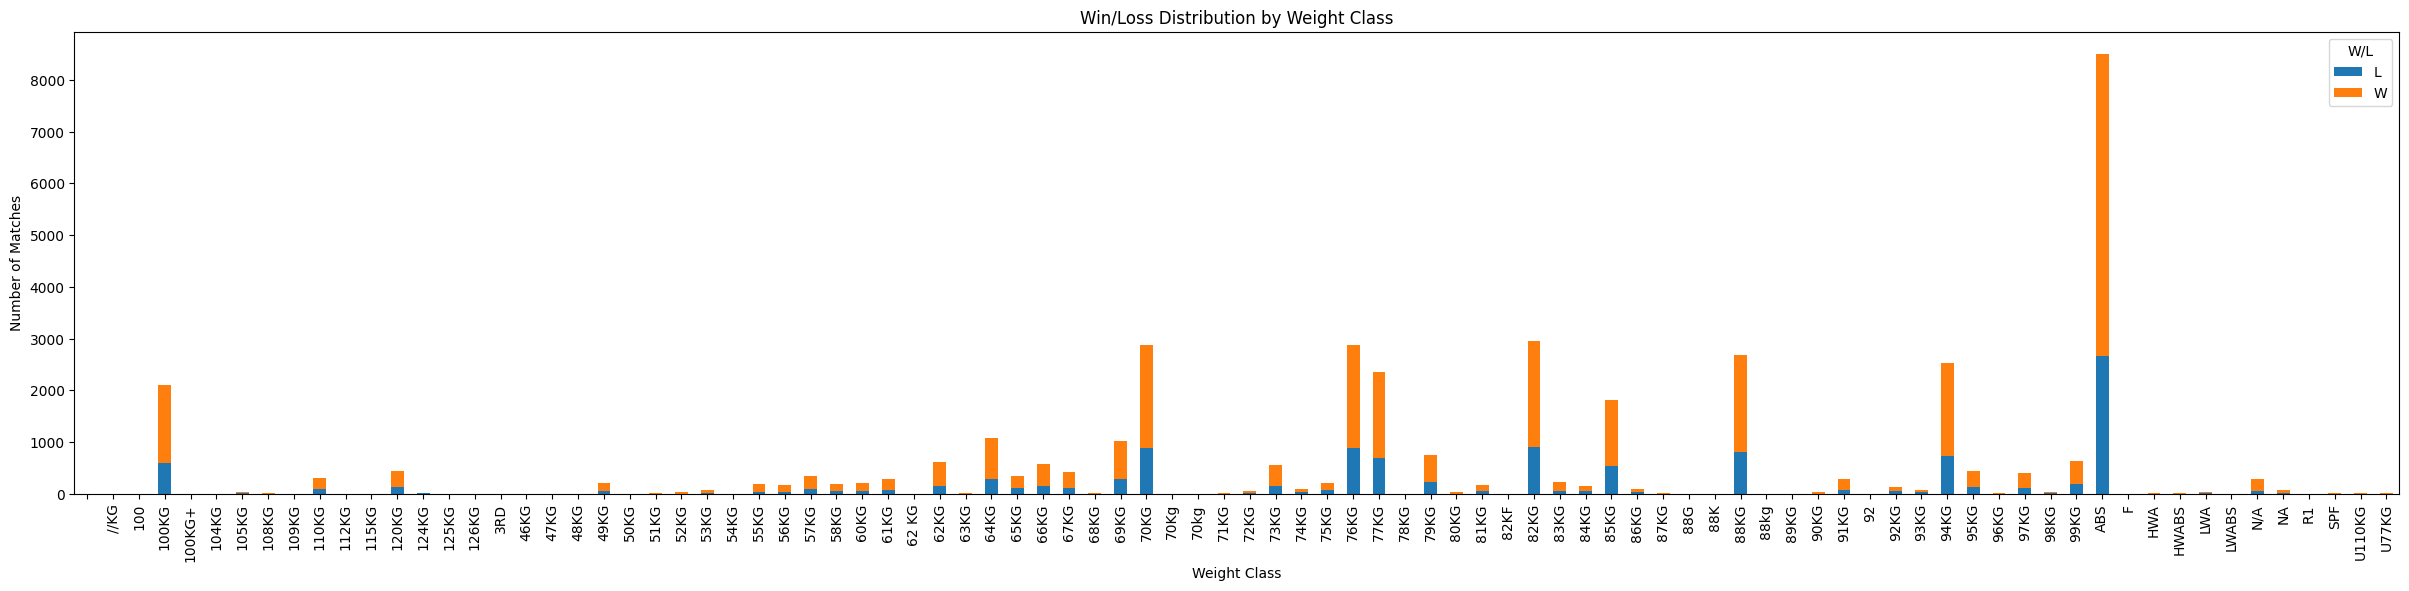

In [54]:
# Grouping by weight class and counting wins and losses
wl_by_weight = data_frame.groupby(['Weight', 'W/L']).size().unstack()

# Plotting
wl_by_weight.plot(kind='bar', stacked=True, figsize=(30, 6))
plt.title('Win/Loss Distribution by Weight Class')
plt.xlabel('Weight Class')
plt.ylabel('Number of Matches')
plt.show()


#### Are there any patterns in victories related to weight classes?

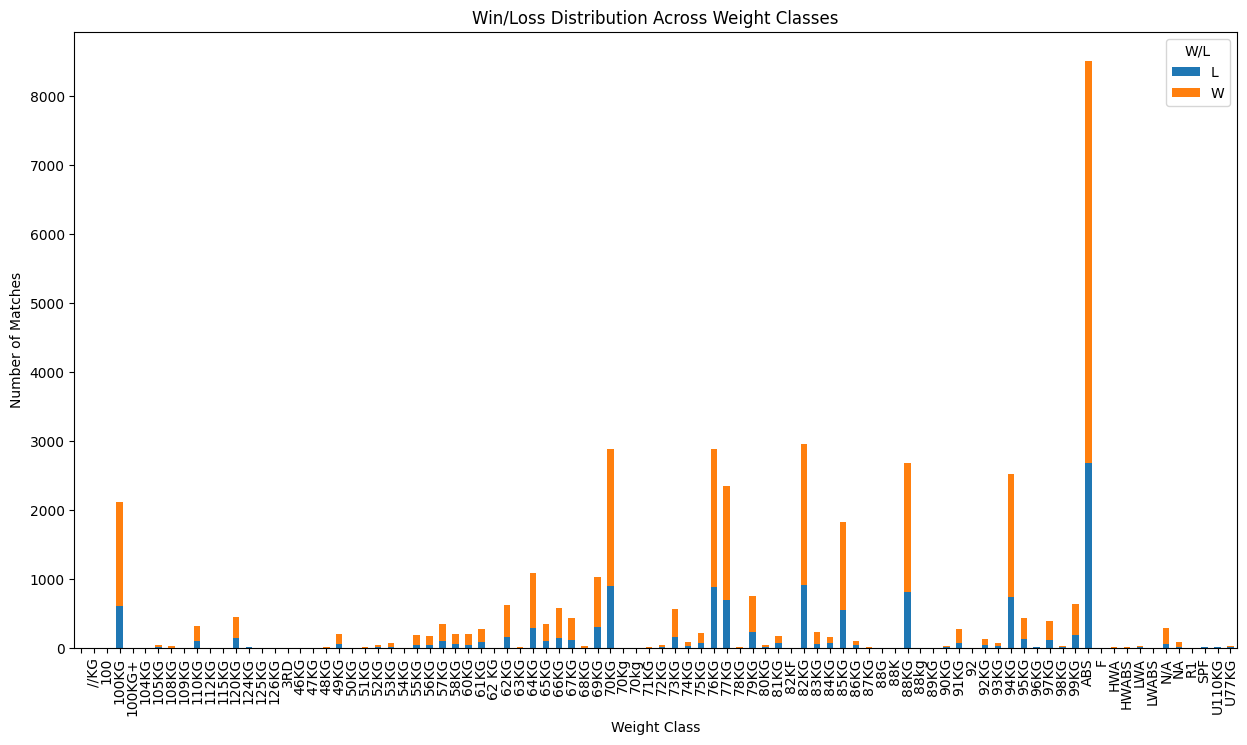

In [55]:
# Ensuring that the 'Weight' and 'W/L' columns are clean
# Assuming you've already corrected the 'Weight' column as previously discussed

# Grouping by weight class and counting wins and losses
wl_by_weight = data_frame.groupby(['Weight', 'W/L']).size().unstack()

# Filling NaN values with 0 for better visualization and calculation
wl_by_weight = wl_by_weight.fillna(0)

# Plotting the results
wl_by_weight.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Win/Loss Distribution Across Weight Classes')
plt.xlabel('Weight Class')
plt.ylabel('Number of Matches')
plt.show()


In [56]:
# Filtering rows where 'Weight' does not match the pattern (e.g., 100KG)
invalid_weight_rows = data_frame[~data_frame['Weight'].str.contains(r'^\d+KG$', na=False)]

# Displaying these rows
print(invalid_weight_rows)

          Id First Name Last Name Nickname      Team                        Opponent W/L            Method       Competition Weight Stage  Year  Points Advantage        Full Name
1       7672      Aaron   Johnson      Tex  Unity JJ              Quentin Rosensweig   L  Inside heel hook          Kakuto 5    ABS   SPF  2015    None      None    Aaron Johnson
3       8785      Aaron   Johnson      Tex  Unity JJ  Richie MartinezRichie Martinez   L         Heel hook  Kakuto Challenge    ABS    SF  2015    None      None    Aaron Johnson
6       9116      Aaron   Johnson      Tex  Unity JJ      Abraham MarteAbraham Marte   L       Cross choke    UAEJJF NYC Pro  HWABS    4F  2016    None      None    Aaron Johnson
7       9373      Aaron   Johnson      Tex  Unity JJ        Andre GalvaoAndre Galvao   L             Choke      Pan American    ABS    R2  2016    None      None    Aaron Johnson
9      10087      Aaron   Johnson      Tex  Unity JJ    Bernardo FariaBernardo Faria   L   Triangle armba

### Comparative Analysis

#### How do the outcomes differ by competition or year?

### Advanced Analysis

#### Is there a correlation between the team size and its success rate?

## Hypothesis Testing

### Are certain methods of winning more prevalent in specific weight classes

### Is ther a significant difference in thenumber of points scored accross different competitions

## Correlation Analysis

Perform correlation tests between selected variables and discuss the outcomes.


In [ ]:
# Check if numerical columns exist and have non-NaN values
numerical_columns = data_frame.select_dtypes(include=['int64', 'float64'])
print("Numerical Columns:", numerical_columns.columns)
print("Data Preview:\n", numerical_columns.head())

# Checking for non-NaN data
print("Count of non-NaN values:\n", numerical_columns.notna().sum())

# Proceed only if there are numerical columns with enough data
if not numerical_columns.empty and numerical_columns.notna().sum().any():
    corr_matrix = numerical_columns.corr()

    # Heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()
else:
    print("No suitable numerical data for correlation matrix.")


## Predictive Analysis

Apply regression analysis based on your identified correlations and interpret the results.


## Conclusions

Summarize the key findings of your analysis, discuss their implications, and provide any recommendations or insights.


## References

List all the references and data sources used in your analysis.
